In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve
from scipy.stats import kendalltau, spearmanr, pearsonr

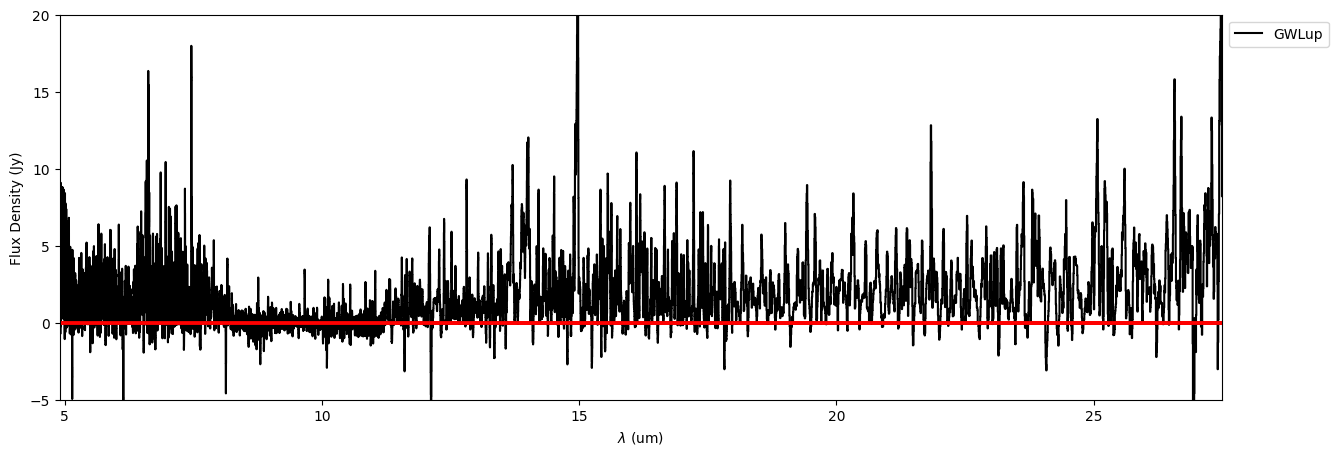

10657


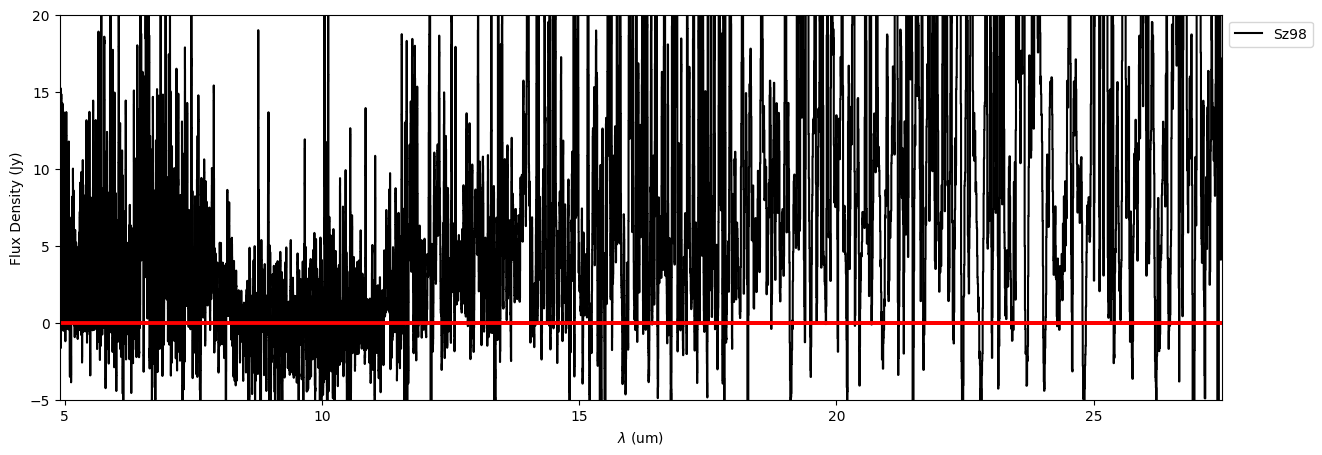

10657


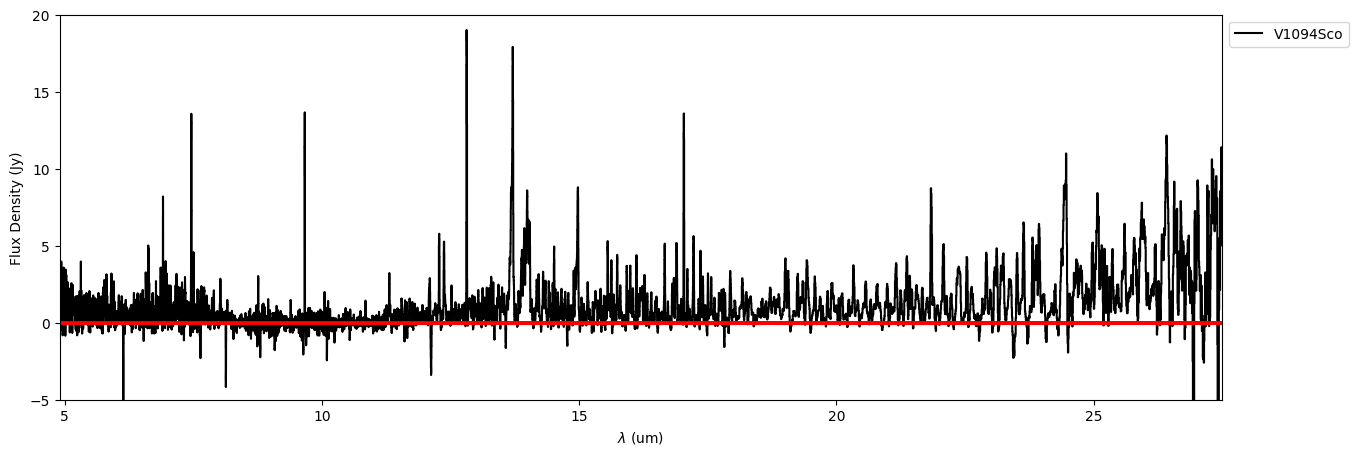

10657


In [18]:
features_df = pd.read_csv("matthias_linelist_combined.csv")

# Wavelength grid
clip_min, clip_max = 4.9, 27.5
feature_mask = np.logical_and(features_df['wavelength'] > clip_min, features_df['wavelength'] < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']

# fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    ax1.step(wavelength, np.convolve(flux_cont_sub, np.ones(5)/5, mode='same')*1000, color='black',where='mid', label=f'{Source}')
    for index, row in features_df[feature_mask].iterrows():
        if row['type'] == 'hydrogen':
            color = 'purple'
            offset = 0.05
        elif row['type'] == 'fine_structure':
            color = 'orange'
            offset = 0.4
        elif row['type'] == 'molecular':
            color = 'blue'
            offset = 0.05
        else:
            color = 'red'
            offset = 0.6
        ax1.axhline(0,  color='red')
        # ax1.axvline(row['wavelength'], linestyle='--', alpha=0.3, color=color)
        # ax1.text(row['wavelength']+0.004, offset, row['name'], transform=ax1.get_xaxis_text1_transform(0)[0], color=color, rotation=90)

    # for specie in species:
    #     ax1.plot(total_wl, avg_flux[specie], alpha=0.7, label=specie)

    # plot decorations
    # ax1.set_xticks([14.9, 14.95, 15])
    ax1.set_xlim(clip_min, clip_max)    
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_xlabel(r'$\lambda$ (um)')
    ax1.set_ylim(-5, 20)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    print(len(wavelength))

In [3]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

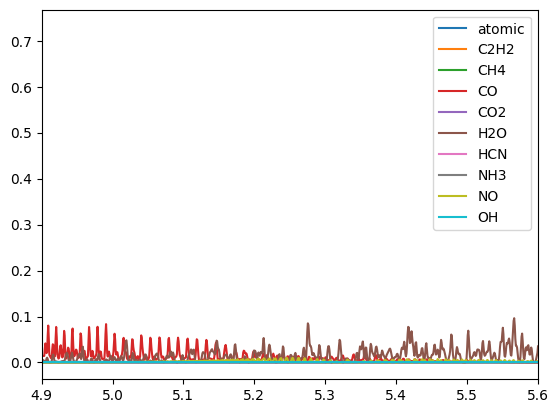

In [5]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie], label=specie)
plt.legend()
plt.xlim(4.9, 5.6)
plt.show()

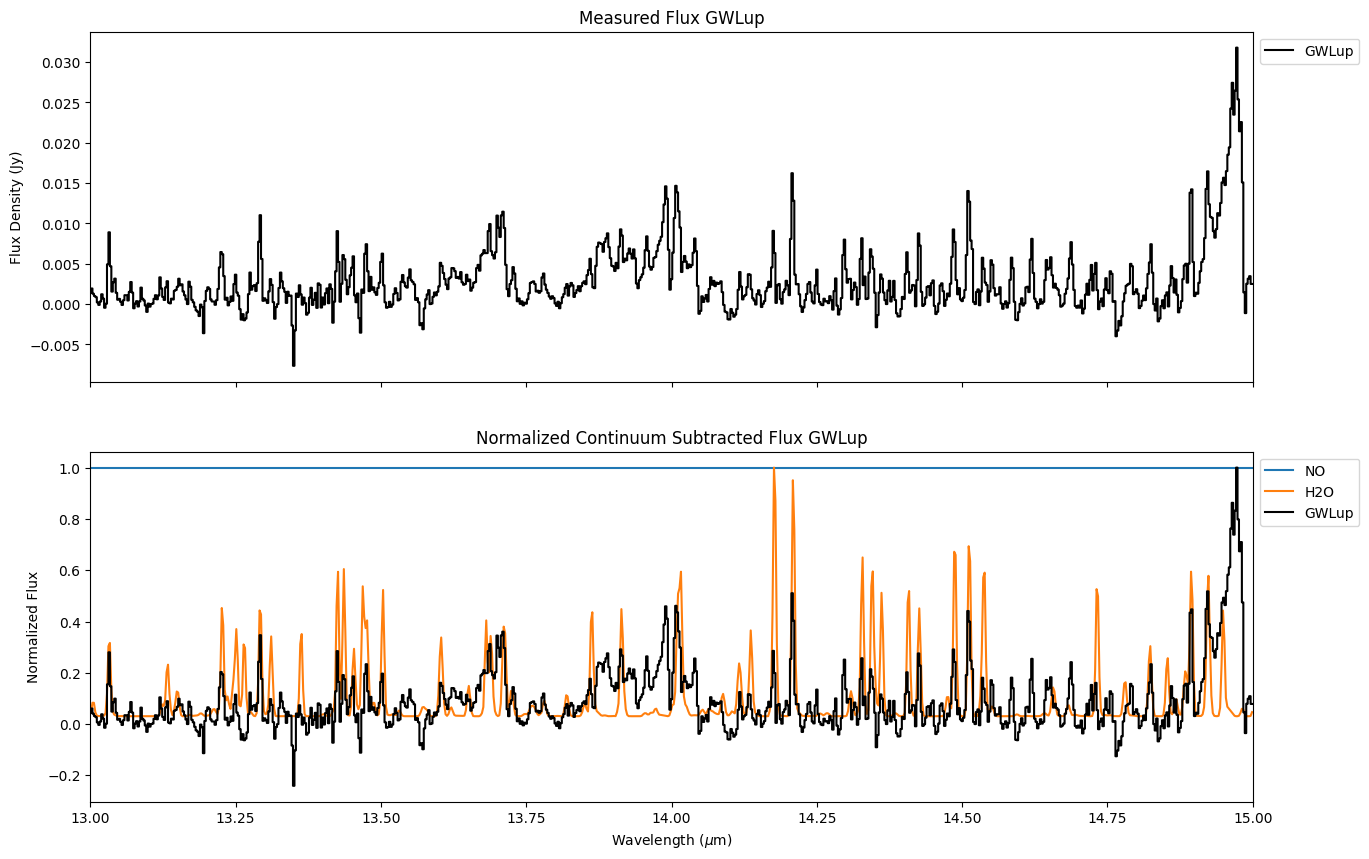

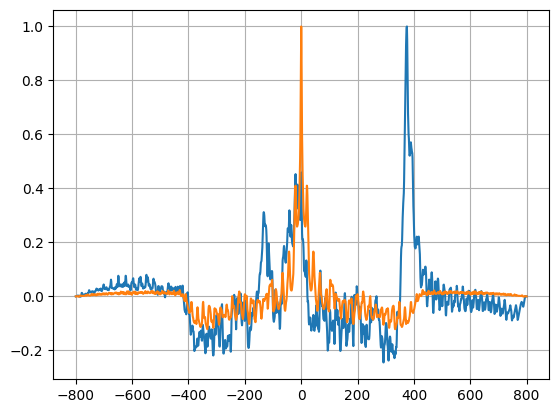

PearsonRResult(statistic=np.float64(0.35577348456618835), pvalue=np.float64(5.713401805717786e-49))


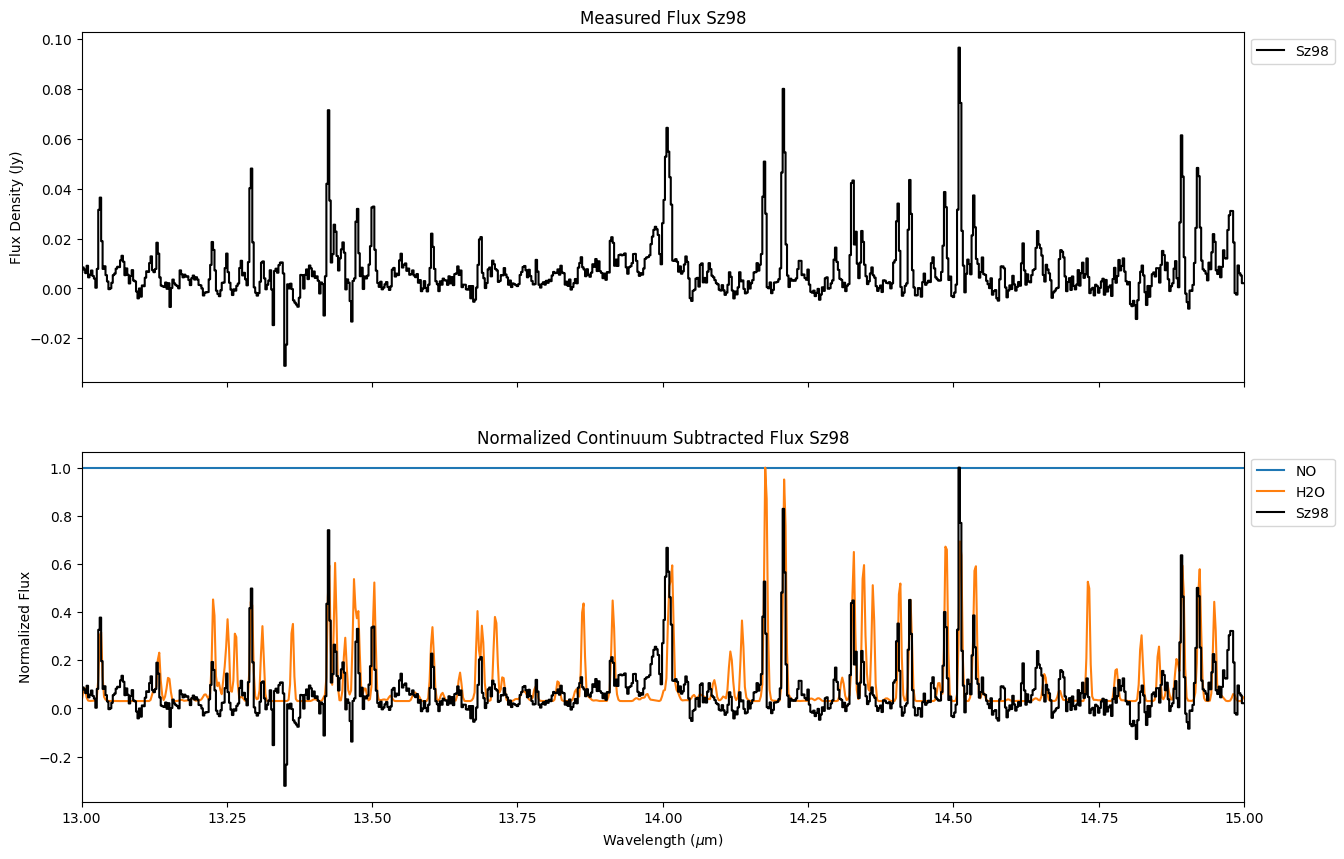

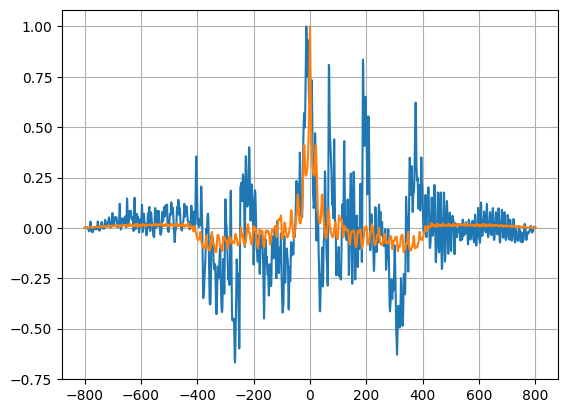

PearsonRResult(statistic=np.float64(0.4845523372590759), pvalue=np.float64(4.964868679704118e-95))


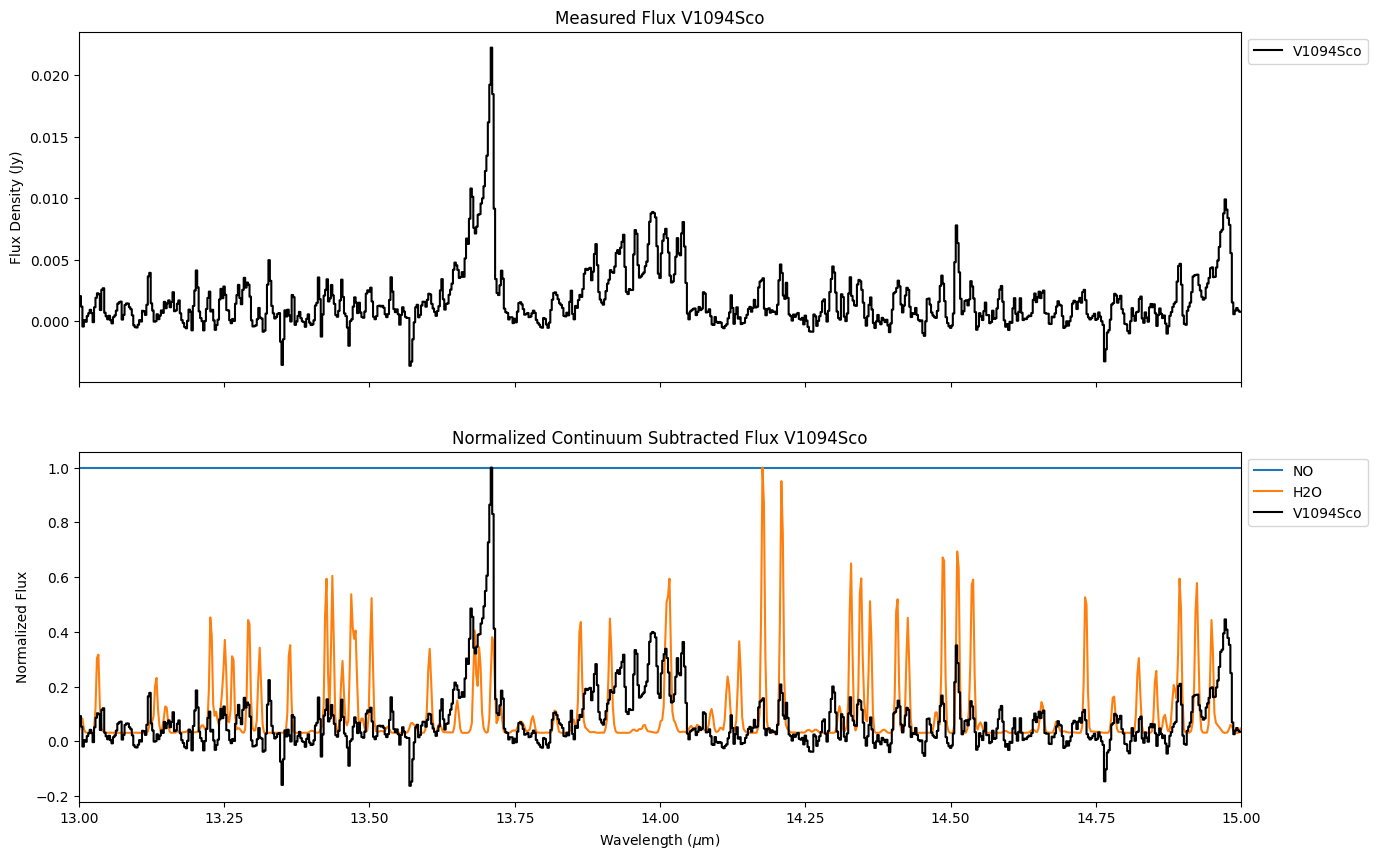

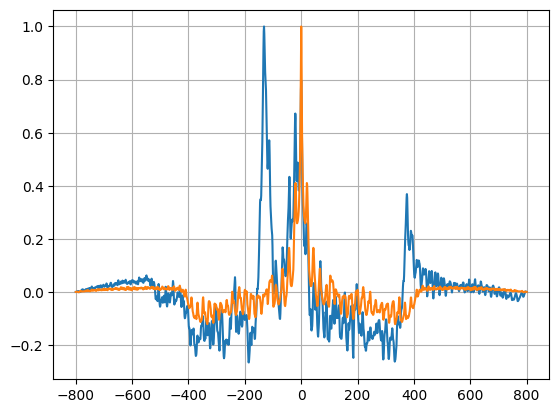

PearsonRResult(statistic=np.float64(0.5830903104164065), pvalue=np.float64(1.8283399384247006e-146))


In [92]:
from scipy.optimize import minimize

clip_min, clip_max = 13, 15
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
# species = ['C2H2', 'H2O', 'HCN', 'NH3', 'OH']
species = ['NO', 'H2O']


def model(params):
    total = np.zeros_like(total_wl)
    for i, specie in enumerate(species):
        total += params[i] * avg_flux[specie]
    # total += params[-1]
    return total


def loss(params):
    if any(param < 0 for param in params):
        return 1e10
    return np.sum((model(params) - flux_cont_sub)[feature_mask] ** 2)


target = 'HCN'

for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    result = minimize(loss, [.1] * (len(species)))
    best_params = result.x
    # print(best_params)
    y_fit = model(best_params)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    ax1.step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    ax1.set_xlim(clip_min, clip_max)
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_title(f'Measured Flux {Source}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.show()
    # plt.figure(figsize=(15, 5))
    for specie in species:
        ax2.plot(total_wl[feature_mask], avg_flux[specie][feature_mask] / max(avg_flux[specie][feature_mask]),
                 label=specie)
    ax2.step(wavelength[feature_mask], flux_cont_sub[feature_mask] / max(flux_cont_sub[feature_mask]), color='black',
             label=Source)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_xlabel(r'Wavelength ($\mu$m)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title(f'Normalized Continuum Subtracted Flux {Source}')
    plt.show()
    cc = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                     (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1], mode='full')
    ac_specie = fftconvolve((avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask])),
                            (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1],
                            mode='full')
    ac_total = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                           (flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask]))[::-1], mode='full')
    # cc = fftconvolve((flux_cont_sub[feature_mask]),
    #                  (avg_flux[target][feature_mask])[::-1], mode='full')
    # ac_specie = fftconvolve((avg_flux[target][feature_mask]),
    #                         (avg_flux[target][feature_mask])[::-1],
    #                         mode='full')
    # ac_total = fftconvolve((flux_cont_sub[feature_mask]),
    #                        (flux_cont_sub[feature_mask])[::-1], mode='full')
    lags = np.arange(-len(flux_cont_sub[feature_mask]) + 1, len(avg_flux[target][feature_mask]))
    plt.plot(lags, cc/max(cc))
    plt.plot(lags, ac_specie/ac_specie[lags==0])
    # plt.title(f'Cross-correlation of {target} and {Source}')
    # plt.xlim(-13, 13)
    plt.grid()
    plt.show()
    print(pearsonr(cc, ac_specie))

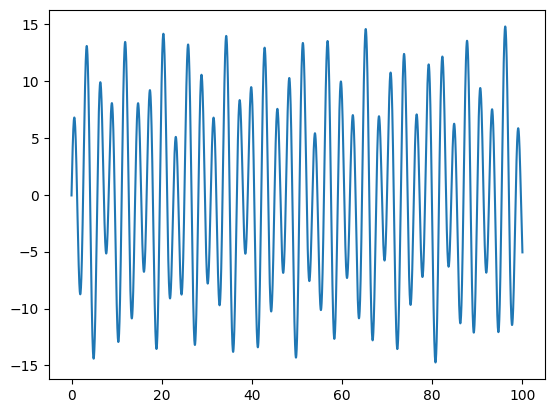

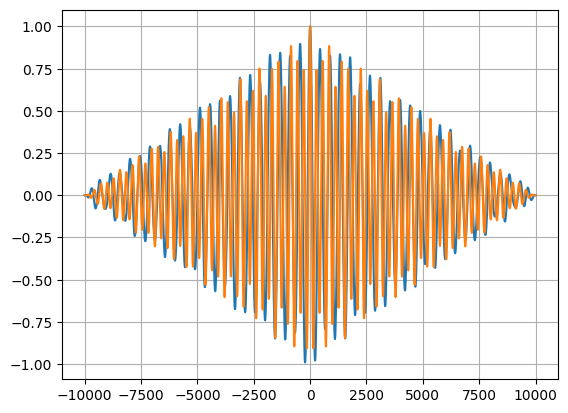

In [32]:
time = np.linspace(0, 100, 10000)
signal = 10*np.sin(np.sqrt(5) * time+0.15) + np.random.randn(len(time))*0
tiny_signal = np.sin(time+0.1)+ 4*np.sin(np.sqrt(2) * time-9)
signal += tiny_signal
plt.plot(time, signal)
plt.show()
cc = fftconvolve(tiny_signal-np.mean(tiny_signal), (signal-np.mean(signal))[::-1], mode='full')
ac = fftconvolve((signal-np.mean(signal)), (signal-np.mean(signal))[::-1], mode='full')
lags = np.arange(-len(signal) + 1, len(signal))
plt.plot(lags, cc/max(cc))
plt.plot(lags, ac/max(ac))
# plt.xlim(-100, 100)
plt.grid()

In [8]:
import numpy as np

def cross_correlation_sn(cross_corr, peak_region_width=5):
    # Find maximum peak
    peak_index = np.argmax(cross_corr)
    peak_value = cross_corr[peak_index]

    # Mask out a region around the peak (to not bias noise estimate)
    mask = np.ones_like(cross_corr, dtype=bool)
    mask[max(0, peak_index - peak_region_width): peak_index + peak_region_width + 1] = False

    # Noise = std of the baseline
    noise_std = np.std(cross_corr[mask])

    # Signal-to-noise ratio
    sn_ratio = peak_value / noise_std
    return sn_ratio

# Example usage:
# cross_corr = your cross-correlation array
# sn = cross_correlation_sn(cross_corr)
# print(f"Signal-to-noise ratio: {sn:.2f}")

In [9]:
def random_shuffle_fap(flux, template, num_trials=1000):
    random_peaks = []

    for _ in range(num_trials):
        shuffled_flux = np.random.permutation(flux)
        cc = fftconvolve(shuffled_flux, template[::-1], mode='same')
        max_peak = np.max(cc)
        random_peaks.append(max_peak)

    return np.array(random_peaks)

# Example usage:
# random_peaks = random_shuffle_fap(flux, template)
# fap = np.mean(random_peaks >= your_real_peak_value)
# print(f"False Alarm Probability: {fap:.5f}")


In [10]:
# Assume you have flux and template
cc_real = np.correlate(flux_cont_sub[feature_mask], avg_flux[target][feature_mask], mode='same')

# Step 1: Calculate S/N
sn = cross_correlation_sn(cc_real, peak_region_width=20)
print(f"S/N of real cross-correlation peak: {sn:.2f}")

# Step 2: Calculate FAP
real_peak = np.max(cc_real)
random_peaks = random_shuffle_fap(flux_cont_sub[feature_mask], avg_flux[target][feature_mask], num_trials=1000)
fap = np.mean(random_peaks >= real_peak)
print(f"False Alarm Probability (FAP): {fap:.5f}")


S/N of real cross-correlation peak: 5.99
False Alarm Probability (FAP): 0.00000


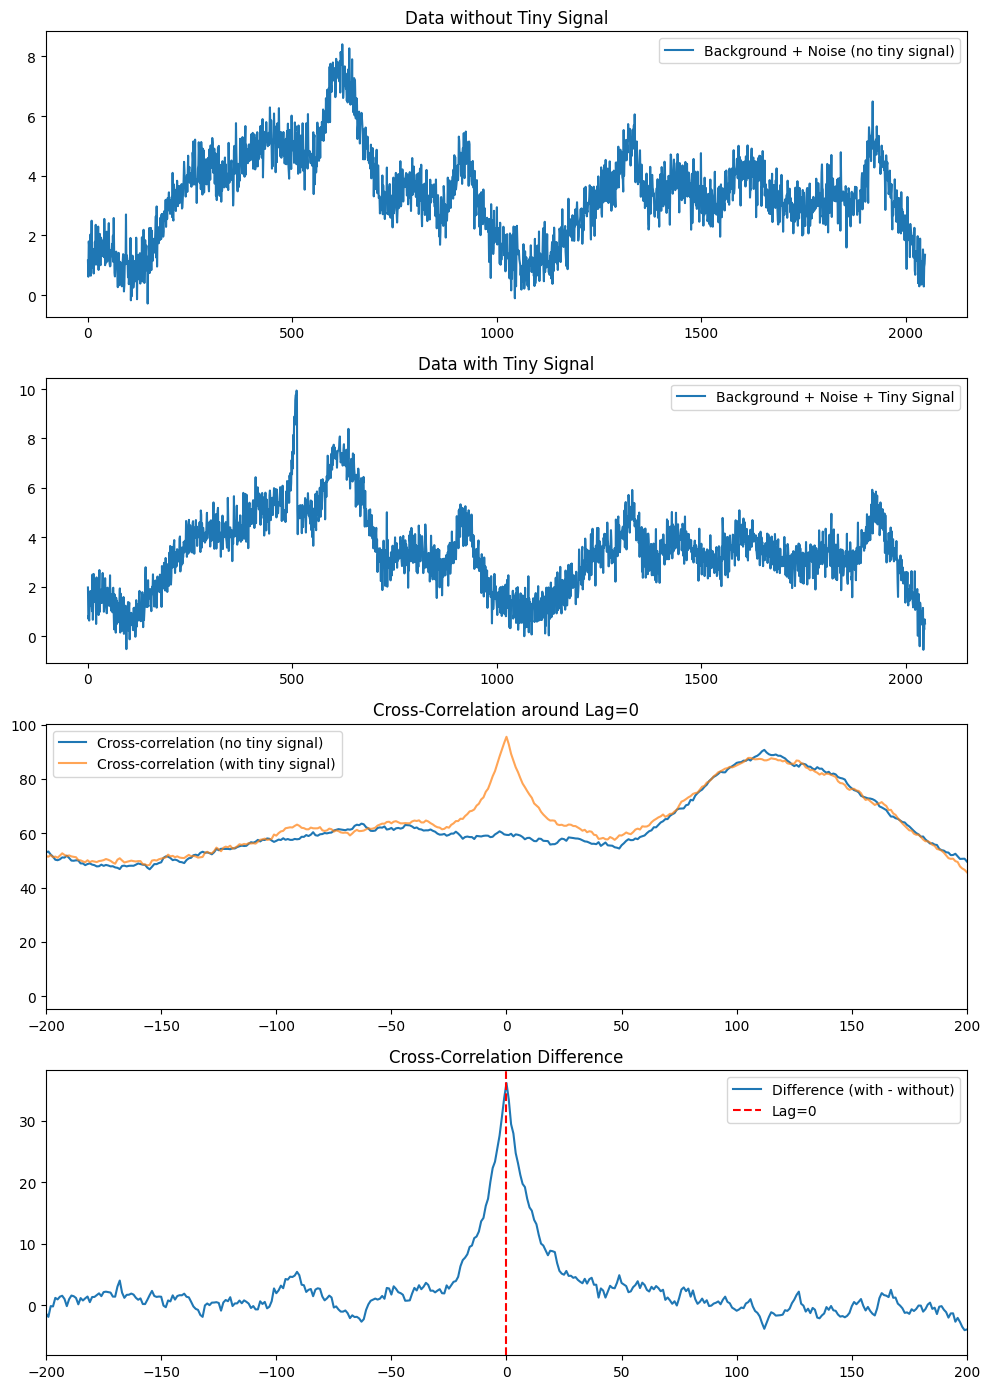

Z-score at lag=0: 3.27
p-value: 5.3168e-04
Detection: YES, tiny signal detected!


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import norm

np.random.seed(42)  # For reproducibility

# --- Settings ---
N = 2048  # length of the data
num_background_signals = 11
noise_level = 0.5  # standard deviation of noise

# --- Generate background signals ---
def generate_random_bumps(N, num_bumps, width_range=(20, 100)):
    x = np.linspace(0, 1, N)
    signal = np.zeros(N)
    for _ in range(num_bumps):
        center = np.random.uniform(0, 1)
        width = np.random.uniform(*width_range) / N
        amplitude = np.random.uniform(0.5, 2.0)
        bump = amplitude * np.exp(-0.5 * ((x - center) / width)**2)
        signal += bump
    return signal

background = np.zeros(N)
for _ in range(num_background_signals):
    background += generate_random_bumps(N, num_bumps=np.random.randint(3, 6))

# --- Generate tiny signal ---
tiny_signal = generate_random_bumps(N, num_bumps=3, width_range=(10, 30))
# Only keep a small section active (simulate small range)
tiny_signal[N//4:N//4*3] = 0  # Zero outside small region

# Normalize tiny signal
tiny_signal /= np.max(np.abs(tiny_signal))

# --- Create datasets ---
# Without tiny signal
data_without_tiny = background +  np.random.normal(0, noise_level, N)

# With tiny signal
data_with_tiny = background + 6 * tiny_signal + np.random.normal(0, noise_level, N)

# --- Cross-correlate ---
corr_without = correlate(data_without_tiny, tiny_signal, mode='full')
corr_with = correlate(data_with_tiny, tiny_signal, mode='full')

lags = np.arange(-N+1, N)

# --- Analyze ---
# Find lag=0 index
lag0_idx = np.where(lags == 0)[0][0]

# Estimate noise from cross-correlation without tiny signal
exclude = 20  # exclude +-20 around lag=0 to avoid leakage
noise_indices = np.where((lags < -exclude) | (lags > exclude))[0]

mu_noise = np.mean(corr_without[noise_indices])
sigma_noise = np.std(corr_without[noise_indices])

# Compute Z-score at lag=0
corr_0 = corr_with[lag0_idx]
Z = (corr_0 - mu_noise) / sigma_noise
p_value = 1 - norm.cdf(Z)

# --- Plot ---
fig, axs = plt.subplots(4, 1, figsize=(10, 14))

axs[0].plot(data_without_tiny, label='Background + Noise (no tiny signal)')
axs[0].set_title('Data without Tiny Signal')
axs[0].legend()

axs[1].plot(data_with_tiny, label='Background + Noise + Tiny Signal')
axs[1].set_title('Data with Tiny Signal')
axs[1].legend()

axs[2].plot(lags, corr_without, label='Cross-correlation (no tiny signal)')
axs[2].plot(lags, corr_with, label='Cross-correlation (with tiny signal)', alpha=0.7)
axs[2].set_xlim(-200, 200)
axs[2].set_title('Cross-Correlation around Lag=0')
axs[2].legend()

axs[3].plot(lags, corr_with - corr_without, label='Difference (with - without)')
axs[3].axvline(0, color='r', linestyle='--', label='Lag=0')
axs[3].set_xlim(-200, 200)
axs[3].set_title('Cross-Correlation Difference')
axs[3].legend()

plt.tight_layout()
plt.show()

print(f"Z-score at lag=0: {Z:.2f}")
print(f"p-value: {p_value:.4e}")

if Z > 3:
    print("Detection: YES, tiny signal detected!")
else:
    print("Detection: NO, not significant enough.")

In [68]:
import numpy as np
from scipy.stats import norm

# Assuming:
# lags = array of lags
# normalized_corr = array of normalized cross-correlation (like you showed)

# Find index corresponding to lag=0
lag0_idx = np.where(lags == 0)[0][0]

# Exclude a small region around lag=0 when estimating noise level
exclude = 5  # exclude [-20, +20] lags
noise_indices = np.where((lags < -exclude) | (lags > exclude))[0]

# Estimate background noise level
mu_noise = np.mean(cc[noise_indices])
sigma_noise = np.std(cc[noise_indices])

# Compute Z-score at lag=0
Z = (cc[lag0_idx] - mu_noise) / sigma_noise

# Get p-value (one-sided test)
p_value = 1 - norm.cdf(Z)

print(f"Z-score at lag=0: {Z:.2f}")
print(f"p-value at lag=0: {p_value:.3e}")

Z-score at lag=0: 2.10
p-value at lag=0: 1.766e-02



Corrected Z-score at lag=0: 5.61


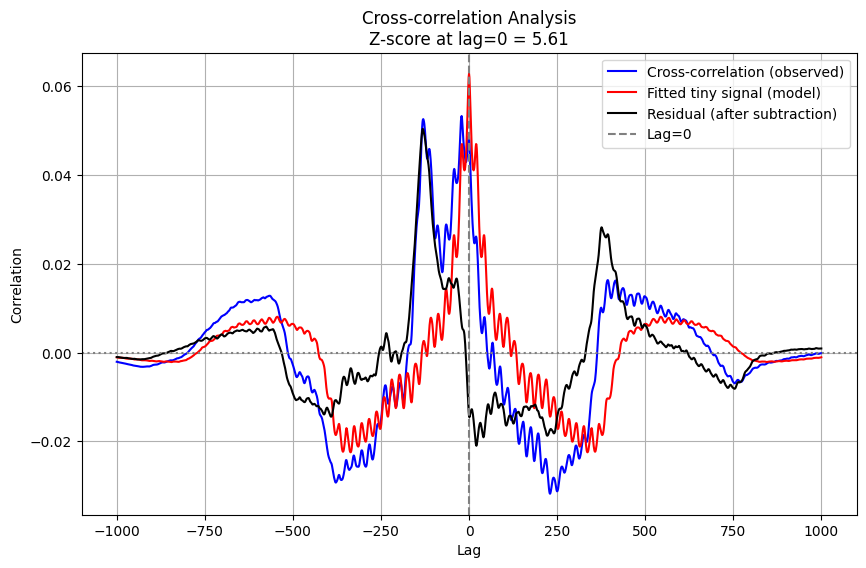

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# --- Load your data here ---
# Big_signal: the data containing strong signals + tiny signal + noise
# Tiny_signal: the small signal template you want to find

# Example placeholder (replace these with your real data arrays)
Big_signal = cc
Tiny_signal = ac_specie

# --- Parameters ---
window = 1000   # How far from lag=0 to consider for fitting
exclude = 20   # How many lags around lag=0 to ignore when estimating noise

# --- 1. Compute cross-correlation ---
lags = np.arange(-len(Big_signal) + 1, len(Big_signal))
cross_corr = correlate(Big_signal, Tiny_signal, mode='full')

# --- 2. Compute autocorrelation of tiny signal ---
auto_corr = correlate(Tiny_signal, Tiny_signal, mode='full')
auto_corr = auto_corr / np.max(auto_corr)  # Normalize

# --- 3. Fit autocorrelation to cross-correlation near lag=0 ---
center = len(lags) // 2  # Index corresponding to lag=0
lag_indices = np.arange(center - window, center + window + 1)

X = auto_corr[lag_indices]    # Template (tiny signal autocorrelation)
Y = cross_corr[lag_indices]   # Observed cross-correlation

# Solve for best scale (linear least squares fit)
beta = np.sum(X * Y) / np.sum(X**2)

# Model the expected contribution
model = beta * X

# Residual
residual = Y - model

# --- 4. Estimate noise standard deviation ---
lags_window = lags[lag_indices] - lags[center]  # Recenter lags around 0

# Mask out ±exclude region around lag=0
noise_mask = (lags_window < -exclude) | (lags_window > exclude)
sigma_noise = np.std(residual[noise_mask])

# --- 5. Calculate Z-score at lag=0 ---
lag0_idx_in_window = np.where(lags_window == 0)[0][0]
Z = beta / sigma_noise

print(f"\nCorrected Z-score at lag=0: {Z:.2f}")

# --- 6. Plot for visualization ---
plt.figure(figsize=(10,6))
plt.plot(lags_window, Y, label='Cross-correlation (observed)', color='blue')
plt.plot(lags_window, model, label='Fitted tiny signal (model)', color='red')
plt.plot(lags_window, residual, label='Residual (after subtraction)', color='black')
plt.axvline(0, color='gray', linestyle='--', label='Lag=0')
plt.axhline(0, color='gray', linestyle=':')
plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()